# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
from collections import Counter
import re
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/cities-of-the-world/cities15000.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')
cities_df = pd.read_csv(r'/kaggle/input/cities-of-the-world/cities15000.csv', encoding = "ISO-8859-1")

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [6]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [8]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [9]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [11]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [13]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
44173,id_644,Warsaw,"['Bar', 'Pub', 'Italian', 'Fusion', 'Vegetaria...",645.0,$,18.0,"[['Good beer, frendly people!', 'Great brews']...",/Restaurant_Review-g274856-d4173513-Reviews-Cz...,d4173513,1,4.5
7629,id_7629,Barcelona,"['Japanese', 'Mediterranean', 'Sushi', 'Fusion...",1423.0,$$ - $$$,41.0,"[['great new sushi restaurant', 'Interesting m...",/Restaurant_Review-g187497-d12488969-Reviews-S...,d12488969,0,0.0
33378,id_14373,London,['French'],14384.0,$$ - $$$,8.0,"[['Good place to visit', 'Poor service, lack o...",/Restaurant_Review-g186338-d1036476-Reviews-Co...,d1036476,1,3.0
37527,id_10609,Paris,['Asian'],10611.0,NaN,6.0,"[['good vibes', 'Small ,cheap and tasty!!'], [...",/Restaurant_Review-g187147-d4341239-Reviews-Dr...,d4341239,1,4.0
37465,id_1335,Madrid,NaN,1337.0,NaN,63.0,"[['excellent!'], ['12/07/2017']]",/Restaurant_Review-g187514-d11905874-Reviews-R...,d11905874,1,4.0


In [14]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

Restaurant_id

In [15]:
data['Restaurant_id_int'] = data['Restaurant_id'].apply(lambda x: float(x[3:]))
data['Restaurant_id_int'].corr(data['Ranking'])

0.8250898929751155

Странная корреляция между ИД ресторана и Ranking. Пока численный ИД ресторана оставим.

City

In [16]:
countries = {
    'Amsterdam': 'Holland',
    'Athens': 'Greece',
    'Barcelona': 'Spain',
    'Berlin': 'Germany',
    'Bratislava': 'Slovakia',
    'Brussels': 'Belgium',
    'Budapest': 'Romania',
    'Copenhagen': 'Denmark',
    'Dublin': 'Ireland',
    'Edinburgh': 'Scotland',
    'Geneva': 'Switzerland',
    'Hamburg': 'Germany',
    'Helsinki': 'Finland',
    'Krakow': 'Poland',
    'Lisbon': 'Portugal',
    'Ljubljana': 'Slovenia',
    'London': 'England',
    'Luxembourg': 'Luxembourg_country',
    'Lyon': 'France',
    'Madrid': 'Spain',
    'Milan': 'Italy',
    'Munich': 'Germany',
    'Oporto': 'Portugal',
    'Oslo': 'Norway',
    'Paris': 'France',
    'Prague': 'Czech',
    'Rome': 'Italy',
    'Stockholm': 'Sweden',
    'Vienna': 'Austria',
    'Warsaw': 'Poland',
    'Zurich': 'Switzerland'
}
data['Сountry'] = data.apply(lambda row: countries[row['City']], axis = 1)

data = pd.get_dummies(data, columns=['Сountry'], dummy_na=True)

In [17]:
city_pop = {}

for city in countries:
    population = cities_df[cities_df.asciiname==city]['population']
    if type(population) is pd.Series:
        try:
            population = population.iloc[0]
        except:
            # непонятно, почему эти 2 города не находятся, нет времени разбираться с ошибкой, поэтому костыль
            if city=='Edinburgh':
                city_pop['Edinburgh'] = 464990
            elif city=='Oporto':
                city_pop['Oporto'] = 249633
            continue
    print(city, population)
    city_pop[city] = int(population)

def find_city_pop(city):
    population = city_pop[city]
    return population

data['City_pop'] = data.City.apply(find_city_pop)

Amsterdam 741636
Athens 664046
Barcelona 1621537
Berlin 3426354
Bratislava 423737
Brussels 1019022
Budapest 1741041
Copenhagen 1153615
Dublin 1024027
Geneva 21806
Hamburg 1739117
Helsinki 558457
Krakow 755050
Lisbon 517802
Ljubljana 272220
London 346765
Luxembourg 76684
Lyon 472317
Madrid 50437
Milan 1236837
Munich 1260391
Oslo 580000
Paris 2138551
Prague 1165581
Rome 2318895
Stockholm 1515017
Vienna 1691468
Warsaw 1702139
Zurich 341730


In [18]:
print(len(data.City_pop.unique()))
data['City_pop'].value_counts(dropna=False)

31


346765     7193
2138551    6108
50437      3813
1621537    3395
3426354    2705
1236837    2694
2318895    2589
1165581    1816
517802     1647
1691468    1443
741636     1372
1019022    1314
1739117    1186
1260391    1145
472317     1126
1515017    1033
1741041    1021
1702139     925
1024027     836
1153615     819
664046      776
464990      745
341730      685
249633      642
21806       590
755050      554
580000      488
558457      475
423737      380
76684       263
272220      222
Name: City_pop, dtype: int64

In [19]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
data = pd.get_dummies(data, columns=['City',], dummy_na=True)

Cuisine Style

In [20]:
data['Cuisine_nan'] = pd.isna(data['Cuisine Style'])

In [21]:
cuisine = Counter()
cuisines = set()
cuisines_variance = []
pattern = re.compile("[a-zA-Z]+\s*[a-zA-Z]*\s*[a-zA-Z]*\s*[a-zA-Z]*\s*[a-zA-Z]*\s*[a-zA-Z]*\s*[a-zA-Z]*")
test = []

# поиск названий кухонь
for x in data['Cuisine Style']:
    try:
        all_cuisines = re.findall(pattern, x)
        test.append(all_cuisines)
    except:
        test.append(['pass'])
        pass

# создание столбца с количеством разных кухонь у ресторана
for cell in test:
    try:
        cuisines_variance.append(len(cell))
        for i in cell:
            cuisine[i] += 1
    except:
        cuisines_variance.append(1)
        pass
data["cuisine_variance"] = cuisines_variance
data.head(3)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Restaurant_id_int,Сountry_Austria,Сountry_Belgium,Сountry_Czech,Сountry_Denmark,Сountry_England,Сountry_Finland,Сountry_France,Сountry_Germany,Сountry_Greece,Сountry_Holland,Сountry_Ireland,Сountry_Italy,Сountry_Luxembourg_country,Сountry_Norway,Сountry_Poland,Сountry_Portugal,Сountry_Romania,Сountry_Scotland,Сountry_Slovakia,Сountry_Slovenia,Сountry_Spain,Сountry_Sweden,Сountry_Switzerland,Сountry_nan,City_pop,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,Cuisine_nan,cuisine_variance
0,id_0,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2138551,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,False,2
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,558457,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,5
2,id_2,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,464990,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,1


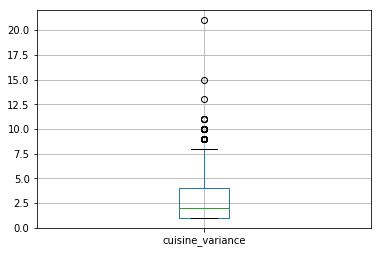

In [22]:
data.boxplot(column=['cuisine_variance'])

In [23]:
data.nunique(dropna=False)

Restaurant_id        13094
Cuisine Style        10732
Ranking              12975
Price Range              4
Number of Reviews     1574
                     ...  
City_Warsaw              2
City_Zurich              2
City_nan                 1
Cuisine_nan              2
cuisine_variance        14
Length: 70, dtype: int64

Price Range

In [24]:
def price_range(text):
    # create price range in digits
    if text == "$$ - $$$":
        return 100
    elif text == "$$$$":
        return 1000
    elif text == "$":
        return 1
    else:
        return 0
    
avg_city_prices = {}


# т.к. случайный лес не обращает внимание на широту распределения признаков, то функция ниже оказывается не нужной
def avg_price_in_city(row):
    if pd.isnull(row['Price Range']):
        row['Price Range'] = avg_city_prices[row.City]
    return row

In [25]:
data['Price Range'] = data['Price Range'].apply(price_range)

# for city in data.City.unique():
#     avg_city_prices[city] = data['Price Range'][data.City == city].mean()

# data["PriceNaN"] = data['Price Range'].isna()
# data = data.apply(avg_price_in_city, axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 70 columns):
Restaurant_id                 50000 non-null object
Cuisine Style                 38410 non-null object
Ranking                       50000 non-null float64
Price Range                   50000 non-null int64
Number of Reviews             46800 non-null float64
Reviews                       49998 non-null object
URL_TA                        50000 non-null object
ID_TA                         50000 non-null object
sample                        50000 non-null int64
Rating                        50000 non-null float64
Restaurant_id_int             50000 non-null float64
Сountry_Austria               50000 non-null uint8
Сountry_Belgium               50000 non-null uint8
Сountry_Czech                 50000 non-null uint8
Сountry_Denmark               50000 non-null uint8
Сountry_England               50000 non-null uint8
Сountry_Finland               50000 non-null uint8
Сountry_Fra

Number of Reviews

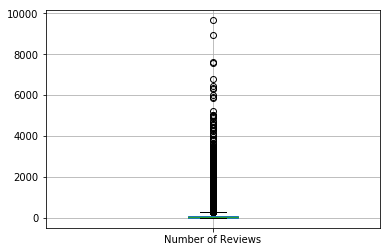

In [26]:
data.boxplot(['Number of Reviews'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f481695ec18>]],
      dtype=object)

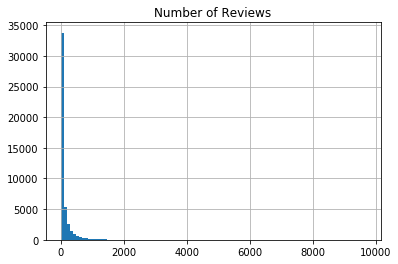

In [27]:
data.hist(column=['Number of Reviews'], bins=100)

In [28]:
print(data.Rating[data.Rating>0].median())
print(data.Rating[data.Rating>0].mean())

4.0
3.9930375


In [29]:
data.Rating[data['Number of Reviews'] > 1000].value_counts()

4.0    291
4.5    284
0.0    144
3.5     82
5.0      8
3.0      7
2.5      1
Name: Rating, dtype: int64

Невооружённым глазом видно, что рестораны с выбросами по количеству отзывов несильно выбиваются из средних оценок. Если успею, вернусь к анализу этого признака более подробно

Reviews

In [30]:
data['Reviews'].value_counts(dropna=False)

[[], []]                                                                                                  8112
NaN                                                                                                          2
[['Very cozy!', 'Service rate: 1'], ['01/17/2016', '11/18/2015']]                                            2
[['ok for beer, not for dinner'], ['12/20/2017']]                                                            2
[['Great Asian Option', 'Wow'], ['10/16/2017', '09/07/2016']]                                                2
                                                                                                          ... 
[['Very tasty French cuisine.', 'Authentic Parisian Restaurant'], ['12/08/2016', '06/10/2016']]              1
[['Wonderful', 'Extremely pleasant dining experience in al...'], ['09/12/2017', '05/24/2017']]               1
[['Yummy and juicy burger', 'My favorite burger joint !'], ['01/17/2017', '12/23/2017']]                     1
[

Есть 8112 пустых отзывов. Отметим их в датасете. Также в столбце есть два NaN

In [31]:
data['Reviews'] = data['Reviews'].fillna('[[], []]')
data['Reviews_nan'] = (data['Reviews']=='[[], []]').astype('float64')

ID_TA

In [32]:
print(len(data['ID_TA'].unique()))
data['ID_TA'].value_counts()

49963


d2010743     2
d2360290     2
d4748208     2
d3685055     2
d7827387     2
            ..
d2062017     1
d11906480    1
d4871871     1
d6639042     1
d7297646     1
Name: ID_TA, Length: 49963, dtype: int64

Какие признаки можно считать категориальными?

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

In [33]:
data.head(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Restaurant_id_int,Сountry_Austria,Сountry_Belgium,Сountry_Czech,Сountry_Denmark,Сountry_England,Сountry_Finland,Сountry_France,Сountry_Germany,Сountry_Greece,Сountry_Holland,Сountry_Ireland,Сountry_Italy,Сountry_Luxembourg_country,Сountry_Norway,Сountry_Poland,Сountry_Portugal,Сountry_Romania,Сountry_Scotland,Сountry_Slovakia,Сountry_Slovenia,Сountry_Spain,Сountry_Sweden,Сountry_Switzerland,Сountry_nan,City_pop,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,Cuisine_nan,cuisine_variance,Reviews_nan
0,id_0,"['Bar', 'Pub']",12963.0,100,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2138551,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,False,2,1.0
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,100,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,558457,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,5,0.0
2,id_2,['Vegetarian Friendly'],810.0,100,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,464990,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,1,0.0
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,1000,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,3.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,346765,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,5,0.0
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,1000,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,423737,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,6,0.0


In [34]:
data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Restaurant_id_int,Сountry_Austria,Сountry_Belgium,Сountry_Czech,Сountry_Denmark,Сountry_England,Сountry_Finland,Сountry_France,Сountry_Germany,Сountry_Greece,Сountry_Holland,Сountry_Ireland,Сountry_Italy,Сountry_Luxembourg_country,Сountry_Norway,Сountry_Poland,Сountry_Portugal,Сountry_Romania,Сountry_Scotland,Сountry_Slovakia,Сountry_Slovenia,Сountry_Spain,Сountry_Sweden,Сountry_Switzerland,Сountry_nan,City_pop,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,Cuisine_nan,cuisine_variance,Reviews_nan
16154,id_780,"['Pub', 'Belgian', 'Cafe', 'Brew Pub', 'Bar']",781.0,100,20.0,"[['So good we came back and brought friends!',...",/Restaurant_Review-g188644-d7289011-Reviews-Af...,d7289011,1,4.5,780.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1019022,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,5,0.0
40590,id_9639,['Cafe'],9648.0,100,14.0,"[['Other diners can be annoying', 'nice visit'...",/Restaurant_Review-g186338-d7257988-Reviews-Th...,d7257988,1,4.0,9639.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,346765,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,1,0.0
16255,id_1289,['Fast Food'],1290.0,0,6.0,"[['Tasty food!!!', 'fair for the charge'], ['1...",/Restaurant_Review-g274887-d7699457-Reviews-Cs...,d7699457,1,4.5,1289.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1741041,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,1,0.0
47036,id_1590,"['Bar', 'Mediterranean', 'European', 'Spanish'...",1592.0,100,218.0,"[['Agradable y bonito. Nice and confortable.',...",/Restaurant_Review-g187514-d8701616-Reviews-El...,d8701616,1,3.5,1590.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,50437,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,False,5,0.0
4312,id_4312,NaN,723.0,0,17.0,"[['Great location, quiet and cozy', 'Fab beer ...",/Restaurant_Review-g189852-d8003998-Reviews-Mo...,d8003998,0,0.0,4312.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1515017,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,True,1,0.0


#### Возьмем следующий признак "Price Range".

In [35]:
data['Price Range'].value_counts()

100     23041
0       17361
1        7816
1000     1782
Name: Price Range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  
*Попробуйте сделать обработку этого признака уже самостоятельно!*

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.

### Посмотрим распределение признака

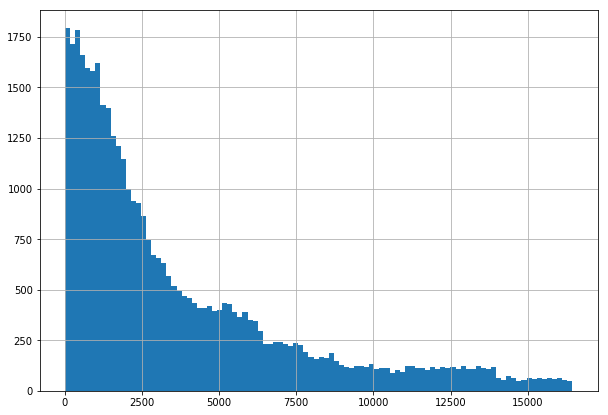

In [36]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

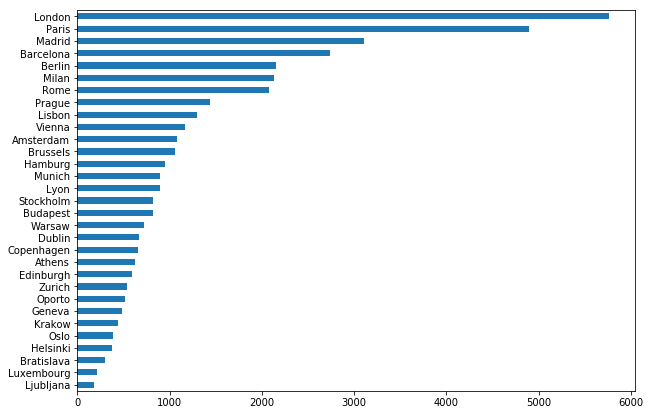

In [37]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

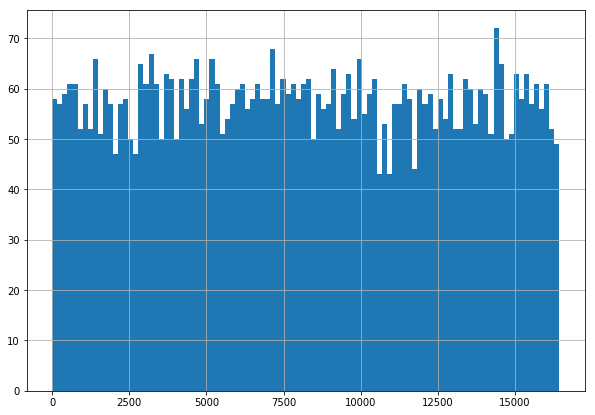

In [38]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

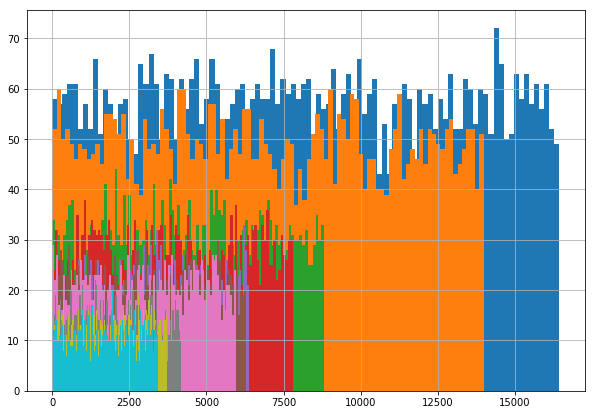

In [39]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


In [40]:
# необходимо отнормировать критерий Ranking по городам City
def ranking_normalize(df):
    
    mean_Ranking_on_City = df.groupby(['City'])['Ranking'].mean()
    count_Restorant_in_City = df['City'].value_counts(ascending=False)
    df['mean_Ranking'] = df['City'].apply(lambda x: mean_Ranking_on_City[x])
    df['count_Restorant'] = df['City'].apply(lambda x: count_Restorant_in_City[x])
    df['Ranking_on_Rest'] = (df['Ranking'] - df['mean_Ranking']) / df['count_Restorant']
    max_Ranking_on_City = df.groupby(['City'])['Ranking'].max()
    df['max_Ranking'] = df['City'].apply(lambda x: max_Ranking_on_City[x])
    df['norm_max_Ranking_in_City'] = (df['Ranking'] - df['mean_Ranking']) / df['max_Ranking']
    
    return df

### Посмотрим распределение целевой переменной

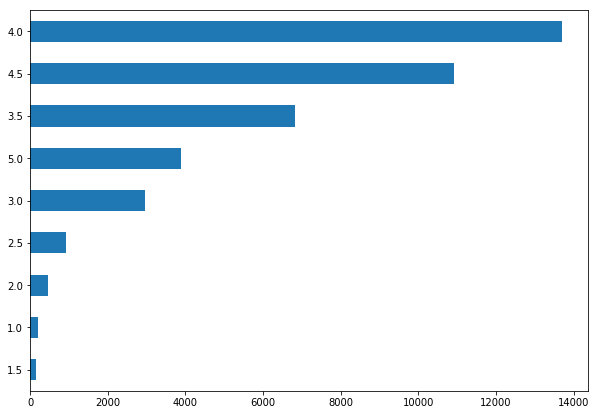

In [41]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

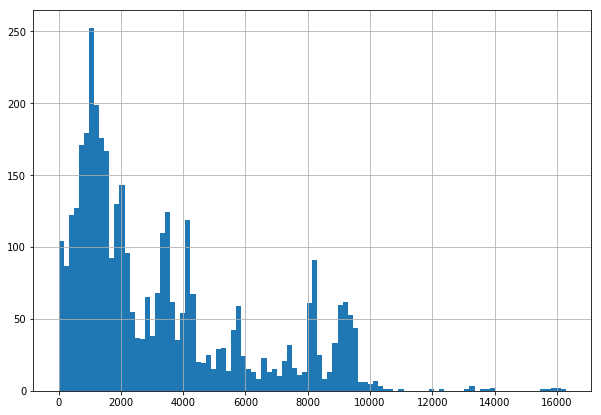

In [42]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

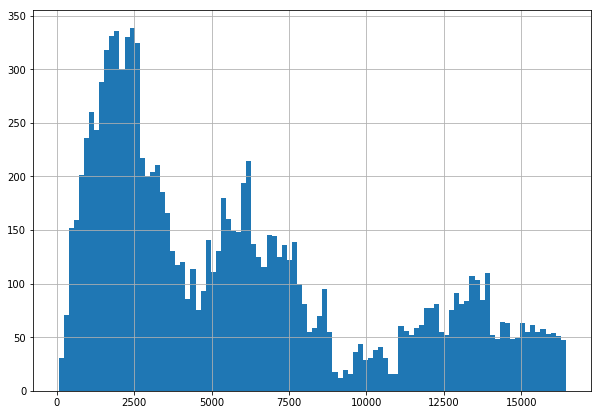

In [43]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

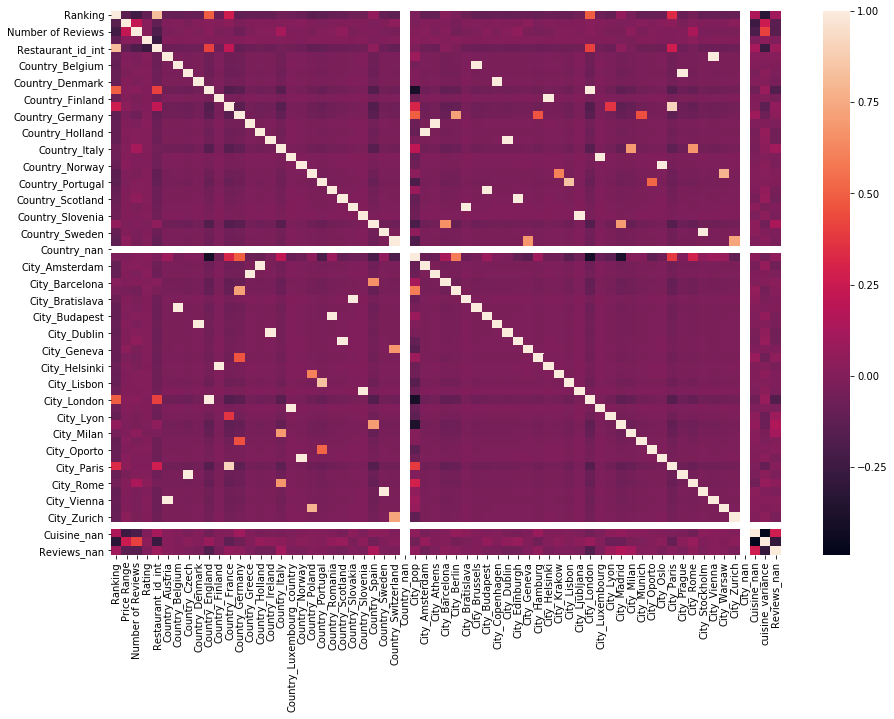

In [44]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [45]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [46]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['Restaurant_id','ID_TA'], axis = 1, inplace=True)
    # замена символов $  в столбце Price Range на числа аналогичного порядка
    df_output['Price Range'] = df_output['Price Range'].apply(price_range)
    

    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    df_output['Number of Reviews'].fillna(0, inplace=True)
    # тут ваш код по обработке NAN
    df_output['Reviews'] = df_output['Reviews'].fillna('[[], []]')
    df_output['Reviews_nan'] = (df_output['Reviews']=='[[], []]').astype('float64')
    
    
    # ################### 3. Encoding ############################################################## 
    # добавление нормализованного ранкинга до удаления столбца City
    df_output = ranking_normalize(df_output)
    # дамми переменная по странам
    df_output['Сountry'] = df_output.apply(lambda row: countries[row['City']], axis = 1)
    df_output = pd.get_dummies(df_output, columns=['Сountry'], dummy_na=True)
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
    
    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # численность населения города, взятая из датасета cities15000.csv
    df_output['City_pop'] = data.City.apply(find_city_pop)
    
    
    
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [47]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,Ranking,Price Range,Number of Reviews,sample,Rating,Reviews_nan,mean_Ranking,count_Restorant,Ranking_on_Rest,max_Ranking,norm_max_Ranking_in_City,Сountry_Austria,Сountry_Belgium,Сountry_Czech,Сountry_Denmark,Сountry_England,Сountry_Finland,Сountry_France,Сountry_Germany,Сountry_Greece,Сountry_Holland,Сountry_Ireland,Сountry_Italy,Сountry_Luxembourg_country,Сountry_Norway,Сountry_Poland,Сountry_Portugal,Сountry_Romania,Сountry_Scotland,Сountry_Slovakia,Сountry_Slovenia,Сountry_Spain,Сountry_Sweden,Сountry_Switzerland,Сountry_nan,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,City_pop
7628,2032.0,100,1893.0,0,0.0,0.0,2970.733102,2589,-0.362585,5948.0,-0.157823,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2318895
21760,4645.0,0,19.0,1,4.5,0.0,6938.557138,6108,-0.375501,13986.0,-0.163989,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2138551
9563,26.0,100,464.0,0,0.0,0.0,8169.707354,7193,-1.132171,16444.0,-0.495239,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,346765
36938,2451.0,100,57.0,1,4.5,0.0,8169.707354,7193,-0.795038,16444.0,-0.347769,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,346765
17374,784.0,100,38.0,1,4.5,0.0,1591.589650,1372,-0.588622,3254.0,-0.248184,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,741636
4257,3540.0,0,52.0,0,0.0,0.0,3106.027840,2694,0.161088,6275.0,0.069159,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1236837
25144,37.0,1,264.0,1,4.5,0.0,1591.589650,1372,-1.133083,3254.0,-0.477747,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,741636
17207,379.0,0,0.0,1,5.0,1.0,462.428947,380,-0.219550,889.0,-0.093846,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,423737
13049,984.0,100,74.0,1,4.5,0.0,2086.979626,1816,-0.607368,4188.0,-0.263367,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1165581
44972,1419.0,100,11.0,1,4.0,0.0,1375.409781,1186,0.036754,2737.0,0.015926,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1739117


In [48]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 68 columns):
Ranking                       50000 non-null float64
Price Range                   50000 non-null int64
Number of Reviews             50000 non-null float64
sample                        50000 non-null int64
Rating                        50000 non-null float64
Reviews_nan                   50000 non-null float64
mean_Ranking                  50000 non-null float64
count_Restorant               50000 non-null int64
Ranking_on_Rest               50000 non-null float64
max_Ranking                   50000 non-null float64
norm_max_Ranking_in_City      50000 non-null float64
Сountry_Austria               50000 non-null uint8
Сountry_Belgium               50000 non-null uint8
Сountry_Czech                 50000 non-null uint8
Сountry_Denmark               50000 non-null uint8
Сountry_England               50000 non-null uint8
Сountry_Finland               50000 non-null uint8
Сountry_

In [49]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [50]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [51]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 67), (40000, 67), (40000, 66), (32000, 66), (8000, 66))

# Model 
Сам ML

In [52]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [53]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [54]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [55]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20800312499999998


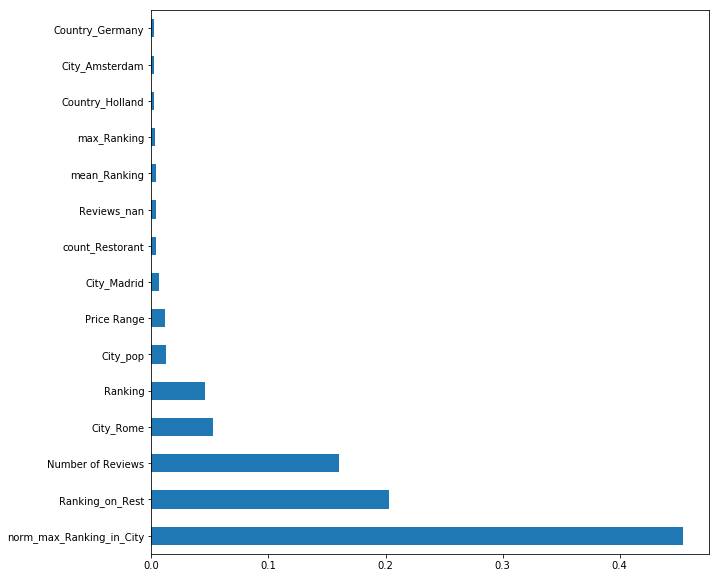

In [56]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [57]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,Rating,Reviews_nan,mean_Ranking,count_Restorant,Ranking_on_Rest,max_Ranking,norm_max_Ranking_in_City,Сountry_Austria,Сountry_Belgium,Сountry_Czech,Сountry_Denmark,Сountry_England,Сountry_Finland,Сountry_France,Сountry_Germany,Сountry_Greece,Сountry_Holland,Сountry_Ireland,Сountry_Italy,Сountry_Luxembourg_country,Сountry_Norway,Сountry_Poland,Сountry_Portugal,Сountry_Romania,Сountry_Scotland,Сountry_Slovakia,Сountry_Slovenia,Сountry_Spain,Сountry_Sweden,Сountry_Switzerland,Сountry_nan,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,City_pop
725,1248.0,1000,136.0,0.0,0.0,2970.733102,2589,-0.665405,5948.0,-0.289632,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2318895
8000,5183.0,0,2.0,0.0,1.0,3106.027840,2694,0.770962,6275.0,0.330992,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1236837
3865,10092.0,100,20.0,0.0,0.0,8169.707354,7193,0.267245,16444.0,0.116899,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,346765
266,2137.0,1,124.0,0.0,0.0,3879.422680,3395,-0.513232,7796.0,-0.223502,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1621537
2796,2612.0,1,16.0,0.0,0.0,3255.417745,2705,-0.237862,6372.0,-0.100976,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3426354
6299,10155.0,0,8.0,0.0,0.0,8169.707354,7193,0.276003,16444.0,0.120731,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,346765
6586,1633.0,100,241.0,0.0,0.0,8169.707354,7193,-0.908760,16444.0,-0.397513,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,346765
8803,623.0,1,90.0,0.0,0.0,972.127990,836,-0.417617,1960.0,-0.178127,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1024027
4982,706.0,100,26.0,0.0,0.0,1370.297817,1145,-0.580173,2763.0,-0.240426,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1260391
3151,943.0,100,45.0,0.0,0.0,1370.297817,1145,-0.373186,2763.0,-0.154650,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1260391


In [58]:
test_data = test_data.drop(['Rating'], axis=1)

In [59]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [60]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [61]:
predict_submission

array([3.275, 4.185, 4.495, ..., 3.06 , 4.395, 4.225])

In [62]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.275
1,id_1,4.185
2,id_2,4.495
3,id_3,4.255
4,id_4,4.450
5,id_5,4.605
6,id_6,1.630
7,id_7,2.870
8,id_8,4.150
9,id_9,4.725


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
